Notebook para analise do modelo LSTM para deteccao de eventos em series temporais.

In [1]:
# imports
%matplotlib inline
import pandas
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,accuracy_score,precision_score,recall_score,confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import datetime
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from estatisticas_time_serie import generate_datasets,readData,general_forecasting,get_forecasts,smooth, lstm_predictions,reject_outliers, noise_generator, train_model_noise_detection, evaluate_model , reject_outliers

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
sensores = [
    '690g-pressao_entrada-vila-aurea-20-04-2016.csv',
    '735g-pressao_media-vila-aurea-20-04-2016.csv',
    '605g-pressao_alta-vila-aurea-20-04-2016.csv',
    '589g-pressao_alta-andreazza-20-04-2016.csv',
    '631g-pressao_ponto_critico-andreazza-20-04-2016.csv',
    '678g-pressao_entrada-andreazza-20-04-2016.csv',
    '690a-vazao-vila-aurea-20-04-2016.csv',
    '450a-vazao-santa-izabel-20-04-2016.csv',
    '450g-pressao_entrada-santa-izabel-20-04-2016.csv',
    '485b-vazao-reno-20-04-2016.csv',
    '485g-pressao_entrada-reno-20-04-2016.csv',
    '525g-pressao_baixa-reno-20-04-2016.csv',
    '573g-pressao_alta-aeroporto-20-04-2016.csv',
    '635g-pressao_ponto_critico-aeroporto-20-04-2016.csv',
    '781a-vazao-aeroporto-20-04-2016.csv',
    '781g-pressao_entrada-aeroporto-20-04-2016.csv',
    '801g-pressao_alta-reno-20-04-2016.csv',
    '830g-pressao_baixa-santa-izabel-20-04-2016.csv',
    '831g-pressao_alta-santa-izabel-20-04-2016.csv'
]

dataframes = []
dataframes_ruidos,inicios_ruidos,inicios_sem_ruidos = [],[],[]
dataframes_ruidos2,inicios_ruidos2,inicios_sem_ruidos2 = [],[],[]

# lendo dados dos sensores
for item in sensores:
    # lendo csv
    dataframe = pandas.read_csv(item, engine='python', skipfooter=3)
    data_matrix = dataframe.as_matrix()
    # removendo valores nulos
    data_matrix = data_matrix[340519:,2:]

    data_convolution = np.array(data_matrix).ravel()

    newV=[]
    for idx,val in enumerate(data_convolution):
        # checking
        if not data_convolution[idx] == 'null' and not np.isnan(data_convolution[idx]): 
            newV.append(float(data_convolution[idx]))

    newV = np.array(newV)
    newV = reject_outliers(newV,m=1)
    # se for vazao, suavizar
    if not (item.split('-')[0][-1] == 'g'):
        newV = smooth(newV, 10, window='hanning')
    
    # adicionando ao array de dataframes e salvando inicio e fim dos ruidos
    dataframes.append(newV)
    train_size = int(len(newV) * 0.8)
    data_noised = newV[train_size:]
    
    data_ruido, inicio_ruidos, inicio_sem_ruidos = noise_generator(data_noised)
    data_ruido_two_way, inicio_ruidos_two_way, inicio_sem_ruidos_two_way = noise_generator(data_noised,two_way=True)
    
    dataframes_ruidos.append(data_ruido)
    dataframes_ruidos2.append(data_ruido_two_way)
    inicios_ruidos.append(inicio_ruidos)
    inicios_sem_ruidos.append(inicio_sem_ruidos)
    inicios_ruidos2.append(inicio_ruidos_two_way)
    inicios_sem_ruidos2.append(inicio_sem_ruidos_two_way)
    
    # plotando resultados
    """plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(newV,label='values')
    plt.plot(data_ruido,label='ruidos')
    plt.title('Time Serie of Vila Aurea Normalized')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()"""

In [48]:
observed_window = 420
horizon = 30
# treinando e avaliando modelo para deteccao dos ruidos

accuracies=[]
precisions=[]

for i in range(0, len(dataframes_ruidos)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    # normalizando datasets
    datasetLstm = scaler.fit_transform(dataframes[i])
    datasetLstm_ruido = scaler2.fit_transform(dataframes_ruidos[i])
    
    # gerando datasets de treino/teste (com/sem ruido)
    train_data_lstm, test_data_lstm,y_seq_data_lstm = generate_datasets(datasetLstm,look_back = 420,pred_horizon=30)
    train_data_lstm_ruido, test_data_lstm_ruido,y_seq_data_lstm_ruido = generate_datasets(datasetLstm_ruido,look_back = 420,pred_horizon=30)

    trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
    testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
    testXlstm_ruido, testYlstm_ruido   = test_data_lstm[0], test_data_lstm[1]
    
    # mudando formato para [exemplos, time steps, features]
    trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
    testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))
    testXlstm_ruido = np.reshape(testXlstm_ruido, (testXlstm_ruido.shape[0], 1, testXlstm_ruido.shape[1]))

    print(testXlstm.shape, testXlstm_ruido.shape)
    print("sensor : ", sensores[i])
    print("training lstm")
    # criando modelo lstm
    model = Sequential()
    model.add(LSTM(10, input_dim=420))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainXlstm, trainYlstm, nb_epoch=10, batch_size=128, verbose=0)
    
    # fazendo o forecasting no conjunto de teste para definir o threshold dinamicamente
    # com relacao ao erro encontrado.
    print("definindo threshold ...")
    forecast_LSTM = general_forecasting(testXlstm, model,method='lstm', strategy_approach='sliding_windows', slidding_window_len=30)
    forecast_LSTM  = scaler.inverse_transform(forecast_LSTM)
    y_seq_data_lstm  = scaler.inverse_transform(y_seq_data_lstm)
    
    # definindo threshold
    threshold = mean_squared_error(y_seq_data_lstm,forecast_LSTM)
    # desvio
    standard_deviation = np.std(datasetLstm)
    
    train_size = int(len(datasetLstm) * 0.8)
    data_matrix_real = datasetLstm[train_size:]
    data_matrix_ruido = datasetLstm_ruido
    inicio_ruido = inicios_ruidos[i]
    inicio_sem_ruido = inicios_sem_ruidos[i]
    
    print("obtendo predicoes nas zonas de ruidos e nao ruidos ...")
    # avaliando modelo para detecao dos ruidos
    forecasts, ruido_and_real_values = get_forecasts(data_matrix_real, data_matrix_ruido, inicio_sem_ruido, inicio_ruido, observed_window, horizon)
    
    forecasts  = scaler.inverse_transform(forecasts)
    ruido_and_real_values = scaler.inverse_transform(ruido_and_real_values)
    
    # analise das predicoes nos ruidos
    errors = [mean_squared_error(ruido_and_real_values[idx], forecasts[idx]) for idx in range(len(forecasts))]
    print("Media : ",np.mean(errors))
    print("Max : ",np.max(errors))
    print("Min : ",np.min(errors))

    total_error_found=0
    TP,TN,FP,FN=0.0,0.0,0.0,0.0

    for idx in range(len(errors)):
        # parte com ruidos 
        if idx < len(errors)/2:
            if (errors[idx] > threshold + standard_deviation):
                total_error_found += 1
                TP+=1.0
            else:
                FN+=1.0
        # parte sem ruidos
        else:
            if errors[idx] <= threshold:
                TN+=1.0
            else:
                # atualmente, nao contabilizando fp no erro total
                total_error_found += 1
                FP+=1.0
            
            
    acc = (TP + TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    accuracies.append(acc)
    precisions.append(precision)
    print(" accuracy : ", acc)
    print(" precision : ", precision)
    print(" ruidos inseridos : ", len(ruido_and_real_values)/2)
    print(" total de ruidos encontrados: ", total_error_found)
    
    
    

((27703, 1, 420), (27703, 1, 420))
('sensor : ', '690g-pressao_entrada-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo predicoes nas zonas de ruidos e nao ruidos ...
('Media : ', 0.54110136821307153)
('Max : ', 5.16033904411539)
('Min : ', 0.0021839952788927273)
(' accuracy : ', 0.542713567839196)
(' precision : ', 0.5794392523364486)
(' ruidos inseridos : ', 199)
(' total de ruidos encontrados: ', 62)
((24435, 1, 420), (24435, 1, 420))
('sensor : ', '735g-pressao_media-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo predicoes nas zonas de ruidos e nao ruidos ...
('Media : ', 2.0423099722567741)
('Max : ', 20.204777917680193)
('Min : ', 0.013571453679751485)
(' accuracy : ', 0.475)
(' precision : ', 0.45098039215686275)
(' ruidos inseridos : ', 200)
(' total de ruidos encontrados: ', 46)
((25709, 1, 420), (25709, 1, 420))
('sensor : ', '605g-pressao_alta-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo predico

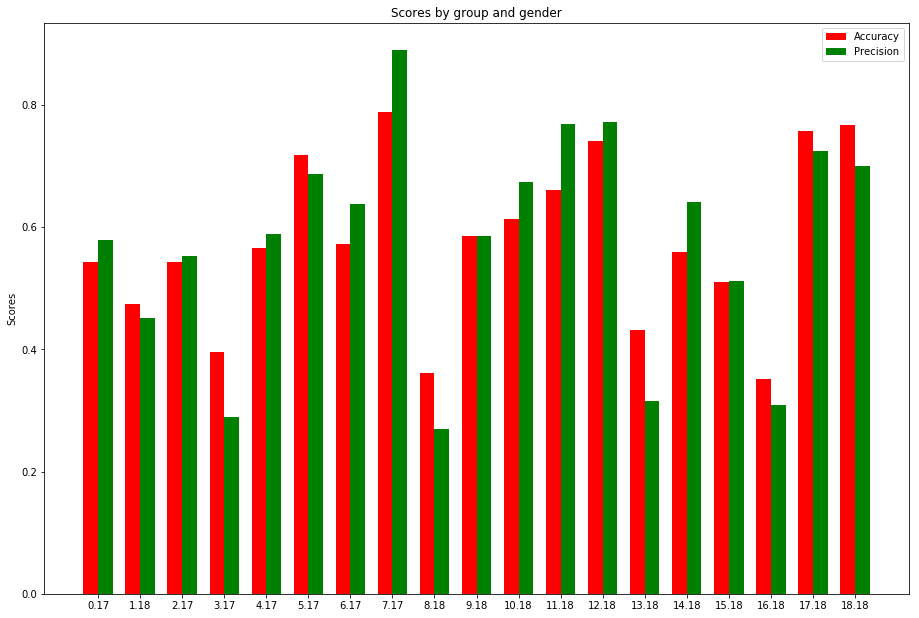

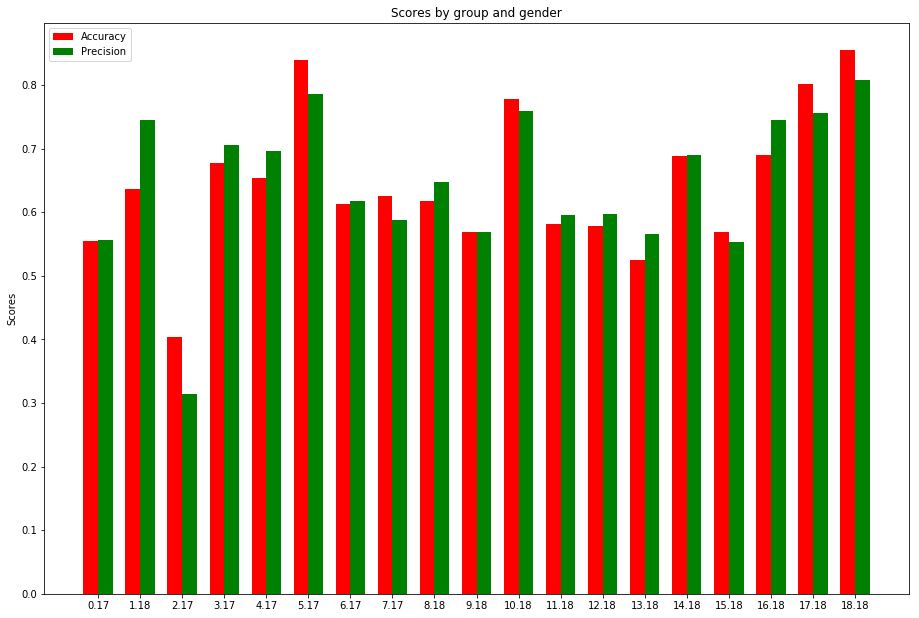

In [51]:
accuracies2 = [0.555,0.6365914786967418,0.40350877192982454,0.6766917293233082,0.6532663316582915,0.84,
             0.6125, 0.6259541984732825, 0.6171284634760705,0.568922305764411,0.7783375314861462,0.5816326530612245,
             0.5789473684210527,0.525,0.6884422110552764,0.568922305764411,0.6893939393939394,0.8017241379310345,
             0.8548387096774194]
precisions2 = [0.5561224489795918,0.7454545454545455,0.3142857142857143,0.7058823529411765, 0.6967741935483871,0.7857142857142857,
             0.6178010471204188,0.5871886120996441,0.6474358974358975,0.5685279187817259,0.7594339622641509,0.5952380952380952,
             0.5974842767295597,0.5657894736842105,0.6903553299492385,0.5525291828793775,0.7450980392156863,0.7560975609756098,
             0.8084112149532711]
N = 19
#men_means = (20, 35, 30, 35, 27)
#men_std = (2, 3, 4, 1, 2)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 10.5)
rects1 = ax.bar(ind, accuracies, width, color='r')

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, precisions, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
#ax.set_xticklabels(('1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Accuracy', 'Precision'))

plt.show()

N = 19
#men_means = (20, 35, 30, 35, 27)
#men_std = (2, 3, 4, 1, 2)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 10.5)
rects1 = ax.bar(ind, accuracies2, width, color='r')

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, precisions2, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
#ax.set_xticklabels(('1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Accuracy', 'Precision'))

plt.show()

In [52]:
# avaliando com os ruÃƒÂ­dos 'two way'

# treinando e avaliando modelo para deteccao dos ruidos
accuracies=[]
precisions=[]


for i in range(0, len(dataframes_ruidos2)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    # normalizando datasets
    datasetLstm = scaler.fit_transform(dataframes[i])
    datasetLstm_ruido = scaler2.fit_transform(dataframes_ruidos2[i])
    
    # gerando datasets de treino/teste (com/sem ruido)
    train_data_lstm, test_data_lstm,y_seq_data_lstm = generate_datasets(datasetLstm,look_back = 420,pred_horizon=30)
    train_data_lstm_ruido, test_data_lstm_ruido,y_seq_data_lstm_ruido = generate_datasets(datasetLstm_ruido,look_back = 420,pred_horizon=30)

    trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
    testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
    testXlstm_ruido, testYlstm_ruido   = test_data_lstm[0], test_data_lstm[1]
    
    # mudando formato para [exemplos, time steps, features]
    trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
    testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))
    testXlstm_ruido = np.reshape(testXlstm_ruido, (testXlstm_ruido.shape[0], 1, testXlstm_ruido.shape[1]))

    print(testXlstm.shape, testXlstm_ruido.shape)
    print("sensor : ", sensores[i])
    print("training lstm")
    # criando modelo lstm
    model = Sequential()
    model.add(LSTM(10, input_dim=420))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainXlstm, trainYlstm, nb_epoch=10, batch_size=128, verbose=0)
     
    # fazendo o forecasting no conjunto de teste para definir o threshold dinamicamente
    # com relacao ao erro encontrado.
    print("definindo threshold ...")
    forecast_LSTM = general_forecasting(testXlstm, model,method='lstm', strategy_approach='sliding_windows', slidding_window_len=30)
    forecast_LSTM  = scaler.inverse_transform(forecast_LSTM)
    y_seq_data_lstm  = scaler.inverse_transform(y_seq_data_lstm)
    
    # definindo threshold
    threshold = mean_squared_error(y_seq_data_lstm,forecast_LSTM)
    # desvio
    standard_deviation = np.std(datasetLstm)
    
    train_size = int(len(datasetLstm) * 0.8)
    data_matrix_real = datasetLstm[train_size:]
    data_matrix_ruido = datasetLstm_ruido
    inicio_ruido = inicios_ruidos2[i]
    inicio_sem_ruido = inicios_sem_ruidos2[i]
    
    print("obtendo predicoes nas zonas de ruidos e nao ruidos ...")
    # avaliando modelo para detecao dos ruidos
    forecasts, ruido_and_real_values = get_forecasts(data_matrix_real, data_matrix_ruido, inicio_sem_ruido, inicio_ruido, observed_window, horizon)
    
    forecasts  = scaler.inverse_transform(forecasts)
    ruido_and_real_values = scaler.inverse_transform(ruido_and_real_values)
    
    # analise das predicoes nos ruidos
    errors = [mean_squared_error(ruido_and_real_values[idx], forecasts[idx]) for idx in range(len(forecasts))]
    print("Media : ",np.mean(errors))
    print("Max : ",np.max(errors))
    print("Min : ",np.min(errors))

    total_error_found=0
    TP,TN,FP,FN=0.0,0.0,0.0,0.0

    for idx in range(len(errors)):
        # parte com ruidos 
        if idx < len(errors)/2:
            if errors[idx] > threshold:
                total_error_found += 1
                TP+=1.0
            else:
                FN+=1.0
        # parte sem ruidos
        else:
            if errors[idx] <= threshold:
                TN+=1.0
            else:
                # atualmente, nao contabilizando fp no erro total
                # total_error_found += 1
                FP+=1.0
            
            
    acc = (TP + TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    #ruidos_gerados.append(len(ruido_and_real_values)/2)
    #ruidos_encontrados.append(total_error_found)
    accuracies.append(acc)
    precisions.append(precision)
    print(" accuracy : ", acc)
    print(" precision : ", precision)
    print(" ruidos inseridos : ", len(ruido_and_real_values)/2)
    print(" total de ruidos encontrados: ", total_error_found)
    

((27703, 1, 420), (27703, 1, 420))
('sensor : ', '690g-pressao_entrada-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo predicoes nas zonas de ruidos e nao ruidos ...
('Media : ', 0.83320159420949402)
('Max : ', 9.0300681475295317)
('Min : ', 0.0025574648194554616)
(' accuracy : ', 0.6992481203007519)
(' precision : ', 0.6945812807881774)
(' ruidos inseridos : ', 199)
(' total de ruidos encontrados: ', 141)
((24435, 1, 420), (24435, 1, 420))
('sensor : ', '735g-pressao_media-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo predicoes nas zonas de ruidos e nao ruidos ...
('Media : ', 1.2145958973756985)
('Max : ', 23.657622429118636)
('Min : ', 0.009325514189195654)
(' accuracy : ', 0.7175)
(' precision : ', 0.8175182481751825)
(' ruidos inseridos : ', 200)
(' total de ruidos encontrados: ', 112)
((25709, 1, 420), (25709, 1, 420))
('sensor : ', '605g-pressao_alta-vila-aurea-20-04-2016.csv')
training lstm
definindo threshold ...
obtendo pr

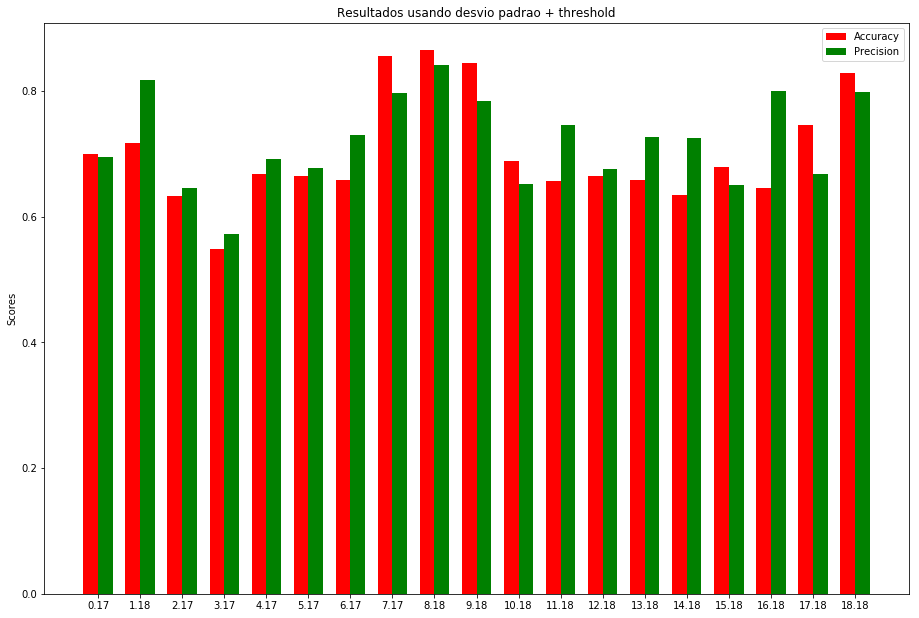

In [53]:
N = 19
#men_means = (20, 35, 30, 35, 27)
#men_std = (2, 3, 4, 1, 2)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 10.5)
rects1 = ax.bar(ind, accuracies, width, color='r')

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, precisions, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Resultados usando desvio padrao + threshold')
ax.set_xticks(ind + width / 2)
#ax.set_xticklabels(('1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Accuracy', 'Precision'))

plt.show()

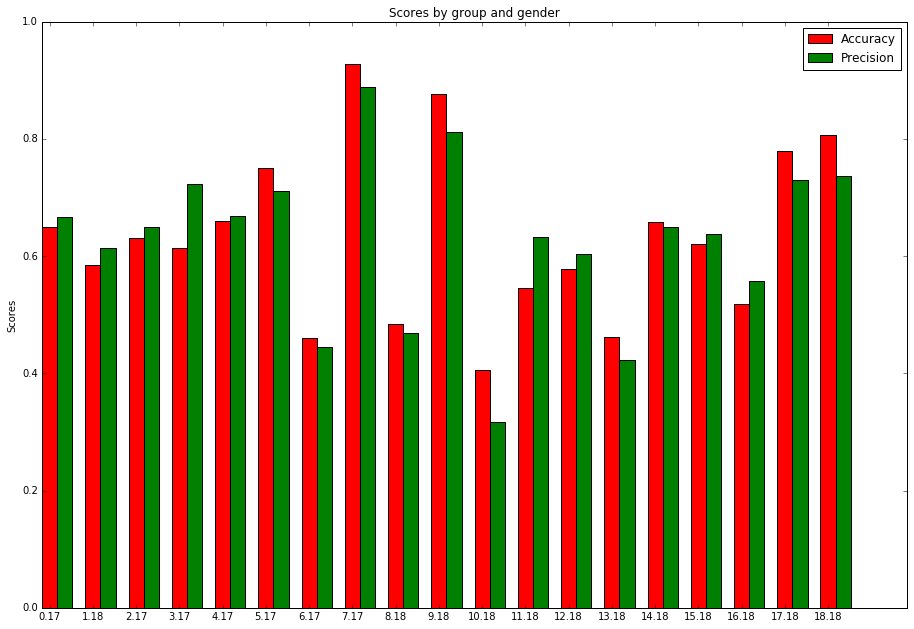

In [15]:
N = 19
#men_means = (20, 35, 30, 35, 27)
#men_std = (2, 3, 4, 1, 2)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 10.5)
rects1 = ax.bar(ind, accuracies, width, color='r')

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, precisions, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
#ax.set_xticklabels(('1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Accuracy', 'Precision'))

plt.show()